## Library setup

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
!pip install transformers==3
#!pip install imbalanced-learn
#import imblearn
#import transformers
#from transformers import AutoModel, BertTokenizerFast
#from biobert_embedding.embedding import BiobertEmbedding
#from simpletransformers.classification import ClassificationModel
#from sklearn.model_selection import KFold
# # Download Wordnet through NLTK in python console:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import accuracy_score

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

     |████████████████████████████████| 754 kB 8.0 MB/s 
     |████████████████████████████████| 895 kB 14.9 MB/s 
     |████████████████████████████████| 3.0 MB 40.0 MB/s 
     |████████████████████████████████| 1.2 MB 45.6 MB/s 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


'Tesla T4'

In [ ]:
import io
from google.colab import files
#uploaded = files.upload()
df = pd.read_csv("mtsamples.csv")
#df = pd.read_csv(io.StringIO(uploaded['mtsamples.csv'].decode('utf-8')))
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
len(df)

4999

In [ ]:
df = df.drop(['Unnamed: 0', 'description', 'sample_name', 'keywords'], axis = 1)
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [ ]:
df.isnull().sum().sum()

33

In [ ]:
df = df.dropna()
#barchart udzialow klas

In [ ]:
len(df)

4966

In [ ]:
group_median = df.groupby(['medical_specialty']).count().median()[0]
group_median

57.0

In [ ]:
grouped_specialties = df.groupby(['medical_specialty']).count()

In [ ]:
len(grouped_specialties.index)

40

In [ ]:
#grouped_specialties = grouped_specialties[grouped_specialties.transcription>=group_median]
#grouped_specialties = grouped_specialties[grouped_specialties.transcription>=100]
grouped_specialties

,transcription
medical_specialty,
Allergy / Immunology,7
Autopsy,8
Bariatrics,18
Cardiovascular / Pulmonary,371
Chiropractic,14
Consult - History and Phy.,516
Cosmetic / Plastic Surgery,27
Dentistry,27
Dermatology,29


In [ ]:
#grouped_specialties['medical_specialty'] = grouped_specialties.index
#grouped_specialties
grouped_specialties.insert(loc=0, column='medical_specialty', value=grouped_specialties.index)
grouped_specialties.reset_index(drop=True, inplace=True)
grouped_specialties

,medical_specialty,transcription
0,Allergy / Immunology,7
1,Autopsy,8
2,Bariatrics,18
3,Cardiovascular / Pulmonary,371
4,Chiropractic,14
5,Consult - History and Phy.,516
6,Cosmetic / Plastic Surgery,27
7,Dentistry,27
8,Dermatology,29
9,Diets and Nutritions,10


Text(0.5, 0, 'Transcription count')

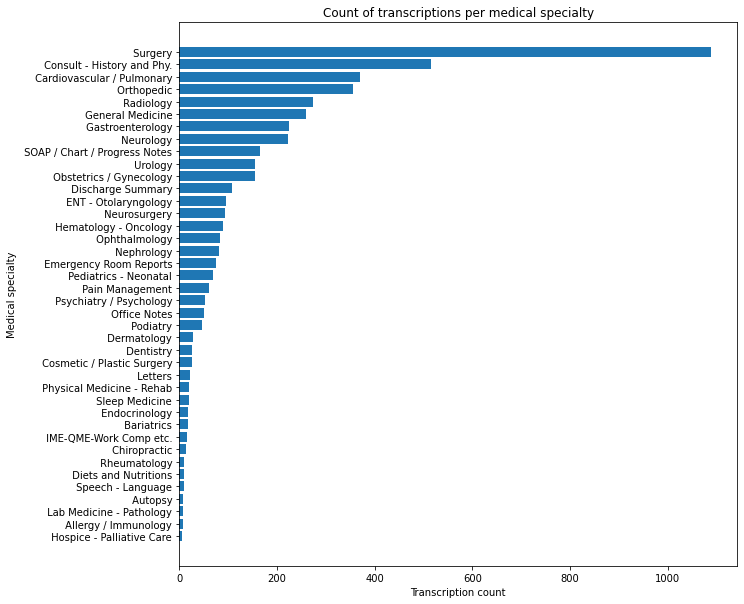

In [ ]:
import matplotlib.pyplot as plt
grouped_specialties = grouped_specialties.sort_values(by=['transcription'])
plotdata = grouped_specialties
plt.figure(figsize=(10, 10))
plt.barh(grouped_specialties['medical_specialty'], grouped_specialties['transcription'])
plt.title("Count of transcriptions per medical specialty")
plt.ylabel("Medical specialty")
plt.xlabel("Transcription count")

In [ ]:
#wziac 4 z najwiekszymi licznosciami
specialties = grouped_specialties['medical_specialty'].tolist()
specialties = specialties[-4:]

In [ ]:
df = df[df['medical_specialty'].isin(specialties)]
df.head()

,medical_specialty,transcription
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
7,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
9,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
11,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [ ]:
df = df.reset_index(drop=True)
df.head()

,medical_specialty,transcription
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [ ]:
#mapowanie specjalizacji
df['medical_specialty'] = df['medical_specialty'].replace(specialties,list(range(len(specialties))))
df.head()

,medical_specialty,transcription
0,1,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,1,1. The left ventricular cavity size and wall ...
2,1,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,1,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,1,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [ ]:
len(df)

2330

In [ ]:
df.columns = ['label','text']

In [ ]:
#lowercase everything
df['text'] = df['text'].apply(lambda text: str(text).lower())
df.head()

,label,text
0,1,"2-d m-mode: , ,1. left atrial enlargement wit..."
1,1,1. the left ventricular cavity size and wall ...
2,1,"2-d echocardiogram,multiple views of the heart..."
3,1,"description:,1. normal cardiac chambers size...."
4,1,"2-d study,1. mild aortic stenosis, widely calc..."


In [ ]:
#remove punctuation
import string
df['text'] = df['text'].apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))
df.head()

,label,text
0,1,2d mmode 1 left atrial enlargement with left...
1,1,1 the left ventricular cavity size and wall t...
2,1,2d echocardiogrammultiple views of the heart a...
3,1,description1 normal cardiac chambers size2 n...
4,1,2d study1 mild aortic stenosis widely calcifie...


In [ ]:
#remove all digits
import re
df['text'] = df['text'].apply(lambda text: re.sub("\d+", " ", text))
df.head()

,label,text
0,1,d mmode left atrial enlargement with left...
1,1,the left ventricular cavity size and wall t...
2,1,d echocardiogrammultiple views of the heart a...
3,1,description normal cardiac chambers size n...
4,1,d study mild aortic stenosis widely calcifie...


In [ ]:
#remove stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
df['text'] = df['text'].apply(lambda text: pattern.sub('', text))
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,text
0,1,mmode left atrial enlargement left atrial...
1,1,left ventricular cavity size wall thickness...
2,1,echocardiogrammultiple views heart great vess...
3,1,description normal cardiac chambers size n...
4,1,study mild aortic stenosis widely calcified ...


In [ ]:
df.iloc[1,1].split(" ")

['',
 '',
 '',
 'left',
 'ventricular',
 'cavity',
 'size',
 'wall',
 'thickness',
 'appear',
 'normal',
 '',
 'wall',
 'motion',
 'left',
 'ventricular',
 'systolic',
 'function',
 'appears',
 'hyperdynamic',
 'estimated',
 'ejection',
 'fraction',
 'nearcavity',
 'obliteration',
 'seen',
 '',
 'also',
 'appears',
 'increased',
 'left',
 'ventricular',
 'outflow',
 'tract',
 'gradient',
 'mid',
 'cavity',
 'level',
 'consistent',
 'hyperdynamic',
 'left',
 'ventricular',
 'systolic',
 'function',
 '',
 'abnormal',
 'left',
 'ventricular',
 'relaxation',
 'pattern',
 'seen',
 'well',
 'elevated',
 'left',
 'atrial',
 'pressures',
 'seen',
 'doppler',
 'examination',
 '',
 '',
 'left',
 'atrium',
 'appears',
 'mildly',
 'dilated',
 '',
 '',
 'right',
 'atrium',
 'right',
 'ventricle',
 'appear',
 'normal',
 '',
 '',
 'aortic',
 'root',
 'appears',
 'normal',
 '',
 '',
 'aortic',
 'valve',
 'appears',
 'calcified',
 'mild',
 'aortic',
 'valve',
 'stenosis',
 'calculated',
 'aortic',
 'va

In [ ]:
len(df.iloc[1,1])

1300

In [ ]:
#usunac spacje
from collections import OrderedDict

df['text'] = df['text'].apply(lambda text: " ".join(list(OrderedDict.fromkeys(text.split(" ")))))

In [ ]:
len(df.iloc[1,1])

807

In [ ]:
df.iloc[1,1]

' left ventricular cavity size wall thickness appear normal motion systolic function appears hyperdynamic estimated ejection fraction nearcavity obliteration seen also increased outflow tract gradient mid level consistent abnormal relaxation pattern well elevated atrial pressures doppler examination atrium mildly dilated right ventricle aortic root valve calcified mild stenosis calculated area cm square maximum instantaneous mean mm mitral annular calcification extending leaflets supportive structures thickening regurgitation tricuspid trace moderate pulmonary artery hypertension pressure mmhg insufficiency pericardial effusion intracardiac mass color suggestive patent foramen ovale lipomatous hypertrophy interatrial septum study somewhat technically limited hence subtle abnormalities could missed'

In [ ]:
# Init the Wordnet Lemmatizer
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

nltk.download('punkt')
lemmatizer = WordNetLemmatizer()
#sentence = "The striped bats are hanging on their feet for best"
#print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#lemmatize
def lemmatize_text(text):
    return ' '.join(lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text))


df['text'] = df.text.apply(lemmatize_text)
df.head()

,label,text
0,1,mmode left atrial enlargement diameter cm norm...
1,1,left ventricular cavity size wall thickness ap...
2,1,echocardiogrammultiple view heart great vessel...
3,1,description normal cardiac chamber size left v...
4,1,study mild aortic stenosis widely calcify mini...


In [ ]:
len(df['text'])

2330

In [ ]:
 from collections import Counter
 from tqdm import tqdm
 from scipy.sparse import csr_matrix
 import math
 import operator
 from sklearn.preprocessing import normalize
 import numpy as np 

In [ ]:
#posprzatac :)
#tworzenie korpusu - kolumna text do listy
corpus = df['text'].tolist()
corpus

'left ventricular cavity size wall thickness appear normal motion systolic function appear hyperdynamic estimate ejection fraction nearcavity obliteration see also increase outflow tract gradient mid level consistent abnormal relaxation pattern well elevate atrial pressure doppler examination atrium mildly dilate right ventricle aortic root valve calcify mild stenosis calculate area cm square maximum instantaneous mean mm mitral annular calcification extend leaflet supportive structure thicken regurgitation tricuspid trace moderate pulmonary artery hypertension pressure mmhg insufficiency pericardial effusion intracardiac mass color suggestive patent foramen ovale lipomatous hypertrophy interatrial septum study somewhat technically limited hence subtle abnormality could miss'

In [ ]:
len(corpus)

2330

https://analyticsindiamag.com/hands-on-implementation-of-tf-idf-from-scratch-in-python/

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
word_tokenize("Ala ma kota, kota ma Ala")

['Ala', 'ma', 'kota', ',', 'kota', 'ma', 'Ala']

In [ ]:
#extract data
processed_text = []

for i in corpus:
  processed_text.append(word_tokenize(i))

processed_text[1]

['left',
 'ventricular',
 'cavity',
 'size',
 'wall',
 'thickness',
 'appear',
 'normal',
 'motion',
 'systolic',
 'function',
 'appear',
 'hyperdynamic',
 'estimate',
 'ejection',
 'fraction',
 'nearcavity',
 'obliteration',
 'see',
 'also',
 'increase',
 'outflow',
 'tract',
 'gradient',
 'mid',
 'level',
 'consistent',
 'abnormal',
 'relaxation',
 'pattern',
 'well',
 'elevate',
 'atrial',
 'pressure',
 'doppler',
 'examination',
 'atrium',
 'mildly',
 'dilate',
 'right',
 'ventricle',
 'aortic',
 'root',
 'valve',
 'calcify',
 'mild',
 'stenosis',
 'calculate',
 'area',
 'cm',
 'square',
 'maximum',
 'instantaneous',
 'mean',
 'mm',
 'mitral',
 'annular',
 'calcification',
 'extend',
 'leaflet',
 'supportive',
 'structure',
 'thicken',
 'regurgitation',
 'tricuspid',
 'trace',
 'moderate',
 'pulmonary',
 'artery',
 'hypertension',
 'pressure',
 'mmhg',
 'insufficiency',
 'pericardial',
 'effusion',
 'intracardiac',
 'mass',
 'color',
 'suggestive',
 'patent',
 'foramen',
 'ovale',


In [ ]:
len(df)

2330

In [ ]:
DF = {}

In [ ]:
DF['Ala']

KeyError: ignored

In [ ]:
#nigdy nie uzywac pustego excepta

DF = {}

for i in range(len(df)):
    tokens = processed_text[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except KeyError:
            DF[w] = {i}


for i in DF:
    DF[i] = len(DF[i])

In [ ]:
DF
#sprawdzic czy to sie poprawnie wyliczylo logicznie

{'mmode': 2,
 'left': 1347,
 'atrial': 192,
 'enlargement': 60,
 'diameter': 97,
 'cm': 565,
 'normal': 1050,
 'size': 317,
 'right': 1326,
 'ventricle': 134,
 'lv': 72,
 'systolic': 132,
 'function': 247,
 'ventricular': 221,
 'ejection': 124,
 'fraction': 120,
 'diastolic': 33,
 'pericardial': 56,
 'effusion': 111,
 'morphology': 8,
 'aortic': 180,
 'valve': 177,
 'mitral': 96,
 'tricuspid': 57,
 'pulmonary': 207,
 'pa': 20,
 'pressure': 734,
 'mmhgdoppler': 1,
 'mild': 394,
 'regurgitation': 89,
 'trace': 63,
 'cavity': 185,
 'wall': 305,
 'thickness': 57,
 'appear': 623,
 'motion': 309,
 'hyperdynamic': 4,
 'estimate': 151,
 'nearcavity': 1,
 'obliteration': 4,
 'see': 694,
 'also': 915,
 'increase': 332,
 'outflow': 21,
 'tract': 85,
 'gradient': 75,
 'mid': 192,
 'level': 492,
 'consistent': 195,
 'abnormal': 143,
 'relaxation': 3,
 'pattern': 72,
 'well': 1507,
 'elevate': 336,
 'doppler': 30,
 'examination': 435,
 'atrium': 70,
 'mildly': 94,
 'dilate': 133,
 'root': 110,
 'cal

In [ ]:
total_vocab_size = len(DF)
total_vocab_size

27922

In [ ]:
total_vocab = [x for x in DF]
print(total_vocab[:20])

['mmode', 'left', 'atrial', 'enlargement', 'diameter', 'cm', 'normal', 'size', 'right', 'ventricle', 'lv', 'systolic', 'function', 'ventricular', 'ejection', 'fraction', 'diastolic', 'pericardial', 'effusion', 'morphology']


In [ ]:
#obsluzyc to normalnie :) zobaczyc co wyleci jako except np zrzuca do zmiennej globalnej ile tych bledow sie pojawilo
#np zrobic x=0 i w excepcie global x i x+=1 i potem pass i sprawdzic jaki odsetek
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

In [ ]:
type(Counter(processed_text[0]))

collections.Counter

In [ ]:
doc = 0

tf_idf = {}

for i in range(len(df)):
    
    tokens = processed_text[i]
    
    counter = Counter(tokens)
    words_count = len(tokens)
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        d_f = doc_freq(token)
        idf = np.log((len(df)+1)/(d_f+1))
        
        tf_idf[doc, token] = tf*idf

    doc += 1

In [ ]:
doc = 0
tf_idf = {}

for i in range(len(df)):
    
    tokens = processed_text[i]
    
    counter = Counter(tokens)
    words_count = len(tokens)
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        d_f = doc_freq(token)
        idf = np.log((len(df)+1)/(d_f+1))
        
        tf_idf[token] = tf*idf

    doc += 1

In [ ]:
type(tf_idf)

dict

In [ ]:

tf_idf

{'aortic': 0.012714207003830504,
 'atrial': 0.011172028924353684,
 'cm': 0.005019356598697072,
 'diameter': 0.010459026931898301,
 'diastolic': 0.025164834014402355,
 'effusion': 0.013612348734263062,
 'ejection': 0.047962932815302554,
 'enlargement': 0.016337124550952674,
 'fraction': 0.04849609989244289,
 'function': 0.010047640775205268,
 'left': 0.0024559432626166133,
 'lv': 0.015531808062275183,
 'mild': 0.012863528073439387,
 'mitral': 0.014257137491176566,
 'mmhgdoppler': 0.2277711438218004,
 'mmode': 0.10910557951422373,
 'morphology': 0.05612957638080341,
 'normal': 0.003571996718200924,
 'pa': 0.016700461706781324,
 'pericardial': 0.010223144273281562,
 'pressure': 0.005175704662883051,
 'pulmonary': 0.008569200565015742,
 'regurgitation': 0.014593017796885613,
 'right': 0.004082439164518476,
 'size': 0.007574149263329203,
 'systolic': 0.012841719779434992,
 'trace': 0.011710650018488878,
 'tricuspid': 0.0165632718766338,
 'valve': 0.014056115239036458,
 'ventricle': 0.010102

In [ ]:
#TU SIE ZACZYNA DOBRE (NIESTETY, JESZCZE POKMINIC Z TYM TF-IDF)
#przypomniec jak to bylo z vectorizerem

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(df['text'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abcd', 'abdomen', 'abdominal', 'able', 'abnormal', 'abnormality', 'access', 'achieve', 'active', 'activity', 'actually', 'acute', 'addition', 'additional', 'adequate', 'adhesion', 'administer', 'admission', 'admit', 'advanced', 'affect', 'age', 'ago', 'agree', 'air', 'alcohol', 'alert', 'alert orient', 'allergy', 'allow', 'alternative', 'anesthesia', 'anesthetic', 'anesthetize', 'angiography', 'angle', 'ankle', 'answer', 'anterior', 'anteriorly', 'antibiotic', 'aorta', 'aortic', 'apex', 'apparent', 'apparently', 'appear', 'appearance', 'apply', 'approach', 'appropriate', 'approximate', 'approximately', 'area', 'arm', 'arterial', 'artery', 'arthritis', 'ask', 'aspect', 'aspirin', 'assessment', 'associate', 'atraumatic', 'atrial', 'attach', 'attachment', 'attempt', 'attention', 'auscultation', 'avoid', 'awake', 'awaken', 'away', 'bad', 'balloon', 'bandage', 'base', 'bed', 'begin', 'benefit', 'benefit alternative', 'betadine', 'bid', 'bilateral', 'bilaterally', 'biopsy', 'bipolar', 'bit

czy jest jakas metoda zeby wybrac liczbe komponentow?

zastosowac metode optymalnego wyboru liczby wartosci osobliwych (im mniej tym latwiej dzialaja klasyfikatory), najlepiej narysowac i np popatrzec i wybrac na oko - tam gdzie gwaltownie spadaja to odciac; albo total variance explained dla kazdego n_components od 10 do konca np i powinno sie robic coraz bardziej plaskie

In [ ]:
# Dimensionality reduction
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=120, random_state=42)
X_svd = svd.fit_transform(tfIdfMat.toarray())
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.49


In [ ]:
len(X_svd)

2330

In [ ]:
len(df)

2330

https://www.kaggle.com/albeffe/text-clustering-tfidf-pca-beginner-tutorial

czy tworzyc chmure wyrazow? - jak chce to moge

In [ ]:
# train validation test split

labels = df['label'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X_svd, labels, stratify=labels,random_state=1)  

In [ ]:
#jak nie miedzy modelami wybieramy to starcza dwa, ale jesli wybieramy pomiedzy to trzeba dac walidacyjny
#zalezy tez od wielkosci datasetu
#musi byc walidacyjny bo przeciez robie finetuning

print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1747, 120)
Test_Set_Size:(583, 120)


poczytac o wyborze modelu: xgboost, random forest? ktory wybrac, czemu? tu xgboost: https://www.kaggle.com/diveki/classification-with-nlp-xgboost-and-pipelines

In [ ]:
from xgboost import XGBClassifier

scale_pos_weight pomyslec nad tym jesli jest niezbilansowana - doczytac

In [ ]:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.05,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=10)

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
predictions

[1,
 3,
 3,
 2,
 0,
 2,
 3,
 3,
 0,
 3,
 2,
 3,
 2,
 0,
 1,
 3,
 3,
 3,
 3,
 3,
 1,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 3,
 0,
 1,
 3,
 1,
 3,
 0,
 1,
 3,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 0,
 0,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 2,
 3,
 3,
 1,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 3,
 1,
 3,
 1,
 1,
 0,
 2,
 2,
 2,
 3,
 0,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 1,
 2,
 3,
 2,
 3,
 3,
 3,
 1,
 0,
 3,
 2,
 3,
 2,
 3,
 2,
 1,
 3,
 3,
 0,
 2,
 3,
 3,
 3,
 1,
 3,
 3,
 0,
 3,
 3,
 2,
 3,
 1,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 2,
 1,
 3,
 2,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 0,
 2,
 3,
 3,
 2,
 3,
 0,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 2,


In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.87%


https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

In [ ]:
type(specialties)

list

In [ ]:
#labels = category_list
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
cm

array([[ 17,   0,  21,  51],
       [  0,  28,  24,  41],
       [  1,   9, 118,   1],
       [  7,   7,   2, 256]])

dla kazdej klasy precision i recall i dla kazdej f1-score; poza tym kappa-cohena

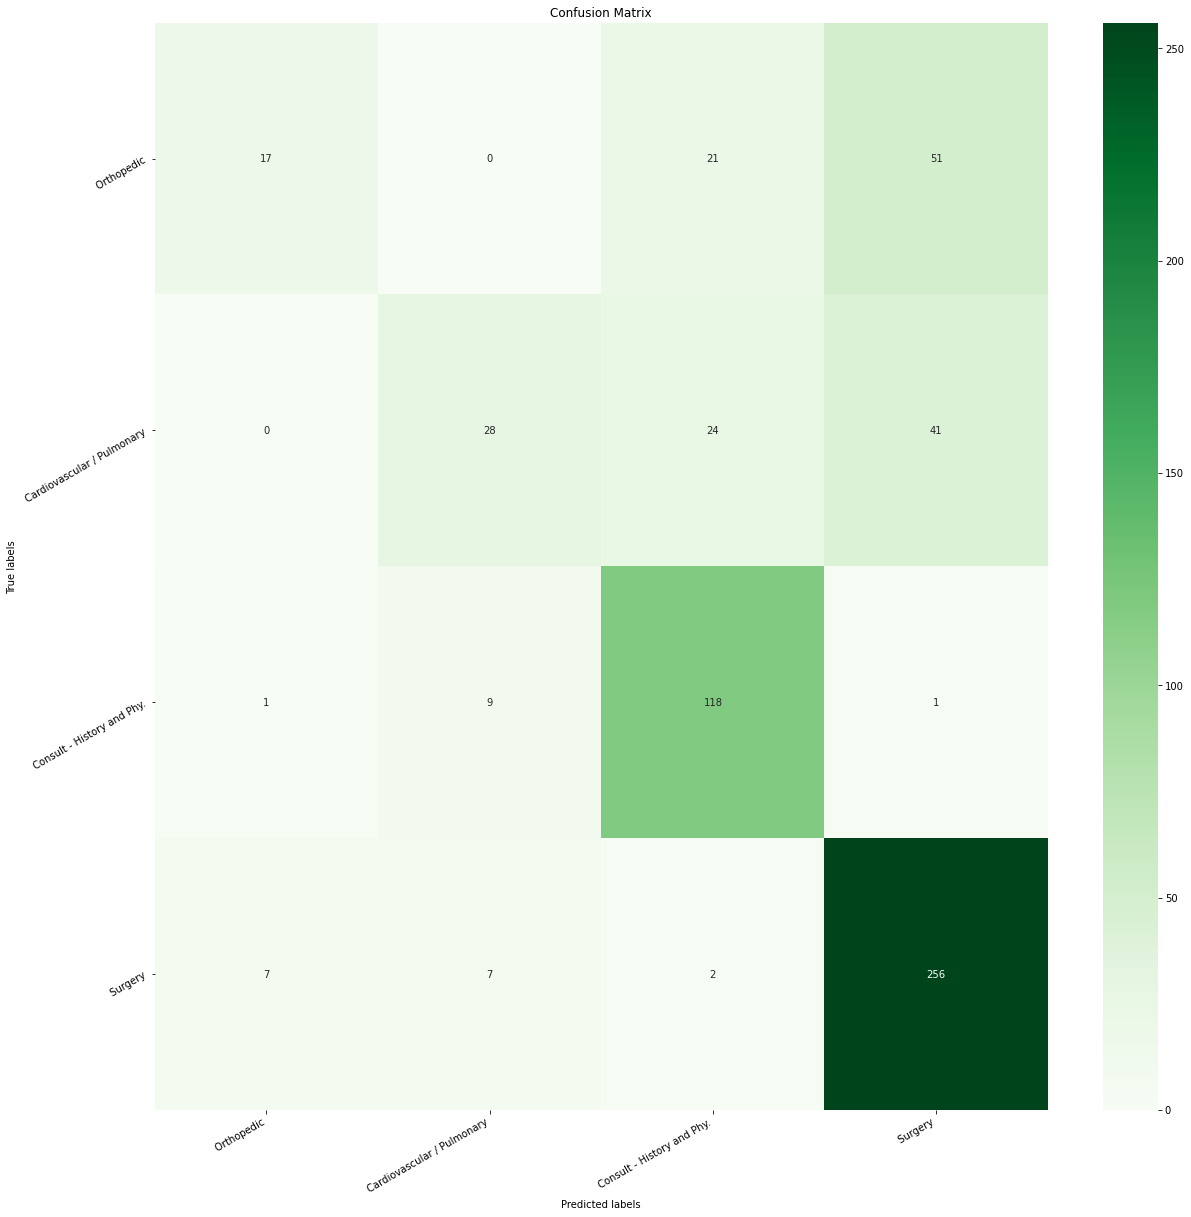

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(specialties); ax.yaxis.set_ticklabels(specialties);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.68      0.19      0.30        89
           1       0.64      0.30      0.41        93
           2       0.72      0.91      0.80       129
           3       0.73      0.94      0.82       272

    accuracy                           0.72       583
   macro avg       0.69      0.59      0.58       583
weighted avg       0.71      0.72      0.67       583



po prostu najlepiej wybrac kilka tych parametrow, zobaczyc co wychodzi i skalibrowac

https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

wybrac jedno

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, predictions, average='weighted')))

Weighted F1-score: 0.68


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

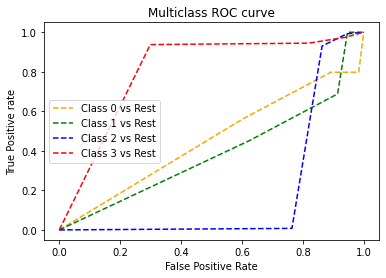

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, predictions, pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('Multiclass ROC',dpi=300); -- zapisywanie do pliku

dodac przekatna i ogarnac skale

1. nowy notebook posprzatany
2. importy na poczatku
3. komorka z markdownem i opisuje co sie dzieje (wczytuje dane do df itd... powinnam dostac...., na kazdej komorce wykonuje.... i w wyniku tego dostaje... itd)
4. kalibrowanie xgboosta - a. scale_pos_weight ze wzgledu na niezbalansowanie proby
5. jak starczy czasu to moze porownac z random forest
6. wprowadzenie, EDA, preprocessing, opis modelu, wynikow - ok 40 stron jest spoko; jesli mniej to trzeba porownac z innym modelem; wziac jakis embedder typu word2vec lub glove ale wyuczony i wstawic do rekurencyjnej sieci typu LSTM

In [ ]:
# Recall
from sklearn.metrics import recall_score
recall_score(y_test, predictions, average='micro')
recall_score

<function sklearn.metrics._classification.recall_score>

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

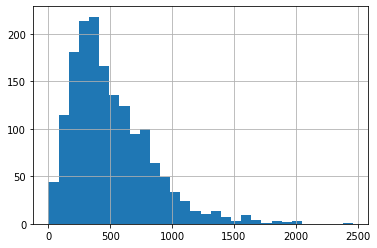

In [ ]:
# ile slow w tekscie
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
#wezmy 750// 512 max niestety

In [ ]:
import textwrap
wrapper = textwrap.TextWrapper(width=80)
testowe = train_text[620]
tokens = tokenizer.tokenize(testowe)
print(wrapper.fill(testowe))

preoperative diagnoses:,1.  status post multiple trauma/motor vehicle
accident.,2.  acute respiratory failure.,3.  acute respiratory
distress/ventilator asynchrony.,4.  hypoxemia.,5.  complete atelectasis of left
lung.,postoperative diagnoses:,1.  status post multiple trauma/motor vehicle
accident.,2.  acute respiratory failure.,3.  acute respiratory
distress/ventilator asynchrony.,4.  hypoxemia.,5.  complete atelectasis of left
lung.,6.  clots partially obstructing the endotracheal tube and completely
obstructing the entire left main stem and entire left bronchial
system.,procedure performed: ,emergent fiberoptic plus bronchoscopy with
lavage.,location of procedure:  ,icu.  room #164.,anesthesia/sedation:,
propofol drip, brevital 75 mg, morphine 5 mg, and versed 8 mg.,history,:  the
patient is a 44-year-old male who was admitted to abcd hospital on 09/04/03
status post mva with multiple trauma and subsequently diagnosed with multiple
spine fractures as well as bilateral pulmonary cont

In [ ]:
print(wrapper.fill(str(' ').join(tokens[0:512])))

pre ##oper ##ative di ##ag ##nose ##s : , 1 . status post multiple trauma /
motor vehicle accident . , 2 . acute respiratory failure . , 3 . acute
respiratory distress / vent ##ila ##tor as ##ync ##hr ##ony . , 4 . h ##y ##pox
##emia . , 5 . complete ate ##lect ##asis of left lung . , post ##oper ##ative
di ##ag ##nose ##s : , 1 . status post multiple trauma / motor vehicle accident
. , 2 . acute respiratory failure . , 3 . acute respiratory distress / vent
##ila ##tor as ##ync ##hr ##ony . , 4 . h ##y ##pox ##emia . , 5 . complete ate
##lect ##asis of left lung . , 6 . c ##lot ##s partially o ##bs ##truct ##ing
the end ##ot ##rac ##hea ##l tube and completely o ##bs ##truct ##ing the entire
left main stem and entire left br ##on ##chia ##l system . , procedure performed
: , emerge ##nt fiber ##op ##tic plus br ##on ##cho ##sco ##py with lava ##ge .
, location of procedure : , i ##cu . room # 164 . , an ##est ##hesia / se
##dation : , prop ##of ##ol d ##rip , br ##ev ##ital 75 mg , m #

In [ ]:
# tokenizacja na zbiorach
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True,
    add_special_tokens=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True,
    add_special_tokens=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True,
    add_special_tokens=True
)

In [ ]:
# konwersja lista -> tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 12

train_data = TensorDataset(train_seq, train_mask, train_y)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)

val_sampler = SequentialSampler(val_data)

val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.2)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,4)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [1.64415323 1.56826923 1.12950139 0.53510499]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    136.
  Batch   100  of    136.

Evaluating...

Training Loss: 1.378
Validation Loss: 1.342

 Epoch 2 / 10
  Batch    50  of    136.
  Batch   100  of    136.

Evaluating...

Training Loss: 1.330
Validation Loss: 1.304

 Epoch 3 / 10
  Batch    50  of    136.
  Batch   100  of    136.

Evaluating...

Training Loss: 1.299
Validation Loss: 1.272

 Epoch 4 / 10
  Batch    50  of    136.
  Batch   100  of    136.

Evaluating...

Training Loss: 1.271
Validation Loss: 1.242

 Epoch 5 / 10
  Batch    50  of    136.
  Batch   100  of    136.

Evaluating...

Training Loss: 1.243
Validation Loss: 1.214

 Epoch 6 / 10
  Batch    50  of    136.
  Batch   100  of    136.

Evaluating...

Training Loss: 1.222
Validation Loss: 1.188

 Epoch 7 / 10
  Batch    50  of    136.
  Batch   100  of    136.

Evaluating...

Training Loss: 1.193
Validation Loss: 1.160

 Epoch 8 / 10
  Batch    50  of    136.
  Batch   100  of    136.

Evaluating...

Training Loss: 1.168
Validat

In [ ]:
!nvidia-smi

Tue May 18 19:20:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    57W / 149W |  11414MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

RuntimeError: ignored

In [ ]:
    import torch
    torch.cuda.empty_cache()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

NameError: ignored